In [8]:
%env JOBLIB_TEMP_FOLDER=/tmp

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import seaborn as sns
sns.set_style('whitegrid')

from PIL import Image
from imageio import imread
import imageio
import skimage
import skimage.io
import skimage.transform
from imageio import imread


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

from skimage.morphology import closing, disk, opening
import random
import time
import copy

from tqdm import tqdm_notebook as tqdm
from os import listdir

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import BatchNormalization

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Dropout
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import model_from_json


from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

from os import listdir
from skimage.segmentation import mark_boundaries

import cv2
import os


env: JOBLIB_TEMP_FOLDER=/tmp


#  **1.**  **Loading Data**

In [9]:
Path_File='../input/v2-plant-seedlings-dataset/nonsegmentedv2/'
subfolders = listdir(Path_File)
print(os.listdir('../input/v2-plant-seedlings-dataset/nonsegmentedv2/'))

['Scentless Mayweed', 'Common wheat', 'Charlock', 'Black-grass', 'Sugar beet', 'Loose Silky-bent', 'Maize', 'Cleavers', 'Common Chickweed', 'Fat Hen', 'Small-flowered Cranesbill', 'Shepherd’s Purse']


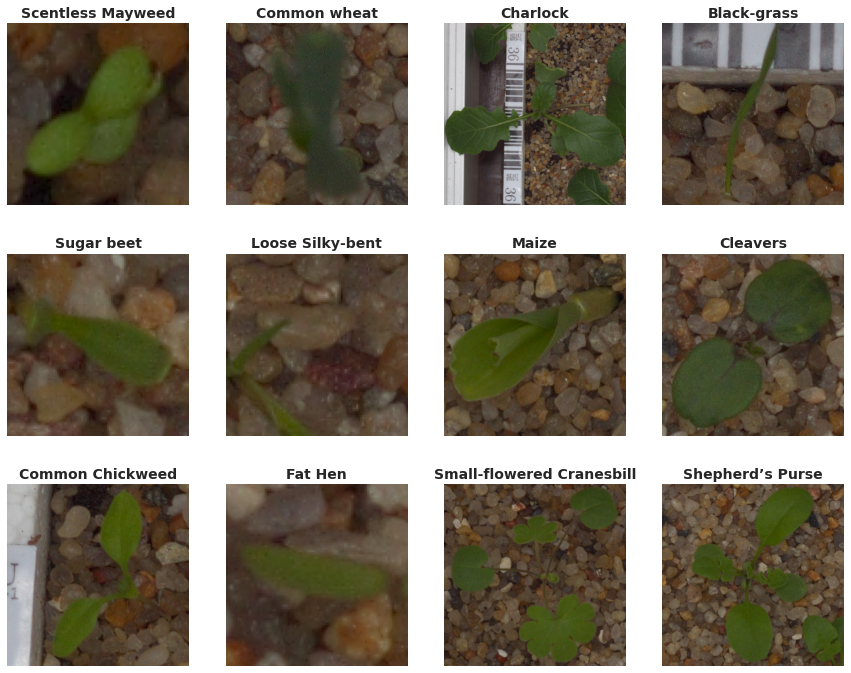

In [10]:
sfc="Small-flowered Cranesbill"
plt.figure(figsize=(15,12))

for n in range(12):
        folder=subfolders[n]
        plt.subplot(3,4,n+1)
        files = listdir(Path_File + folder + "/") 
        image=cv2.imread(Path_File + folder + "/" + files[n+221])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(folder, fontsize=14, weight='bold')

# 2- Image preprocessing:


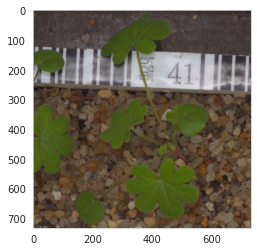

In [11]:
p1 = cv2.imread('/kaggle/input/v2-plant-seedlings-dataset/nonsegmentedv2/Small-flowered Cranesbill/135.png')
p1 = cv2.cvtColor(p1, cv2.COLOR_BGR2RGB)
plt.imshow(p1)
plt.grid(False)
plt.show()

In [12]:
#Using These Function to get rid of the unnecessary pixels.
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
pixel_colors = p1.reshape((np.shape(p1)[0]*np.shape(p1)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

**Visualize the plant image in RGB color space:**

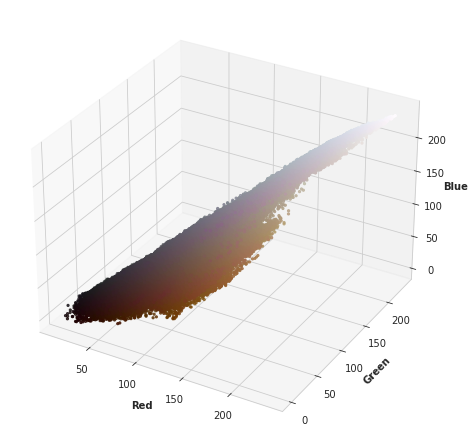

In [13]:
r, g, b = cv2.split(p1)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
set_size(6,6)
pixel_colors = p1.reshape((np.shape(p1)[0]*np.shape(p1)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red", weight='bold')
axis.set_ylabel("Green", weight='bold')
axis.set_zlabel("Blue", weight='bold')

plt.show()


**Visualize the plant image in HSV color space:**

In [14]:
hsv_p1 = cv2.cvtColor(p1, cv2.COLOR_RGB2HSV)

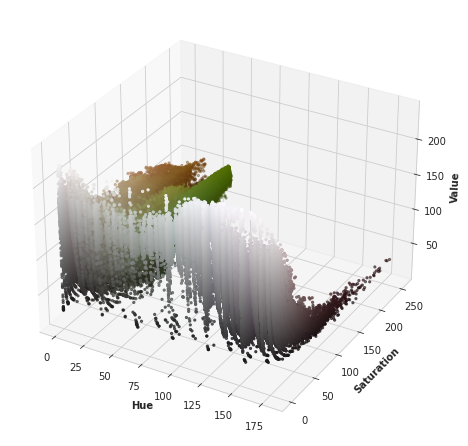

In [15]:
h, s, v = cv2.split(hsv_p1)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")


axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue",weight='bold')
axis.set_ylabel("Saturation", weight='bold')
axis.set_zlabel("Value", weight='bold')
set_size(6,6)
plt.show()

# Segmentation

In [16]:
#Green Color Range 
#minimum green(H=36, S=25, V=25)
#maximum green(H=70, S=255,V=255)

def plot_mask(image, colormin, colormax):
        hsv_p1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)   
        mask = cv2.inRange(hsv_p1, colormin , colormax)
        result = cv2.bitwise_and(image, image, mask=mask)
        plt.figure(figsize=(15,10))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.grid(False)
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap="gray")
        plt.grid(False)
        plt.subplot(1, 3, 3)
        plt.imshow(result)
        plt.grid(False)
        return plt.show()

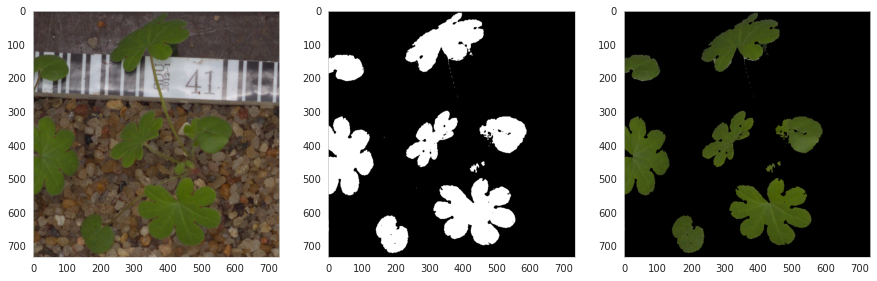

In [17]:
colormin=(36, 25, 25)
colormax=(70, 255,255)

plot_mask(p1, colormin, colormax)

# Segmentation function

In [18]:
def segmented(image):
    foto = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv_foto = cv2.cvtColor(foto, cv2.COLOR_RGB2HSV)
    #print("hsvh",hsv_foto.dtype)
    colormin=(25,50,50)
    colormax=(86,255,255)

    mask = cv2.inRange(hsv_foto, colormin , colormax)
    #print("mask",mask.dtype)
    result = cv2.bitwise_and(foto, foto, mask=mask)
    #print("result",result.dtype)
    pil_image= Image.fromarray(result)


    return result

**Visualize the results of segmentation on the 12 plant species**

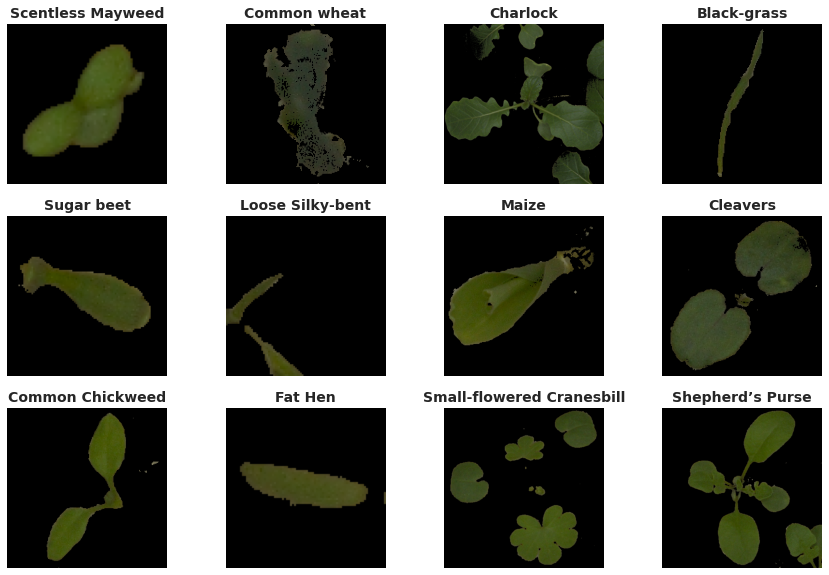

In [19]:
plt.figure(figsize=(15,10))

for n in range(12):
        folder = subfolders[n]
        plt.subplot(3,4,n+1)
        files = listdir(Path_File + folder + "/") 
        image=cv2.imread(Path_File + folder + "/" + files[n+221])
        plt.imshow(segmented(image))
        plt.axis("off")
        plt.title(folder, weight='bold', fontsize=14)


In [20]:
def segmented2(image):
    image=np.array(image)
    #foto=image.copy().astype(np.uint8)
    #foto = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv_foto = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    colormin=(25,50,50)
    colormax=(90,255,255)
    mask = cv2.inRange(hsv_foto, colormin , colormax)
    
    #result = cv2.bitwise_and(foto, foto, mask=mask)
    result = cv2.bitwise_and(image, image, mask=mask)
    result2=np.array(result)
    #pil_image= Image.fromarray(result, mode='RGB')
    #pil_image= Image.fromarray(result)


    return result2

# **VGG16 Model:**

In [38]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2,
#         preprocessing_function = segmented2
       )


train_generator = train_datagen.flow_from_directory(
    '../input/v2-plant-seedlings-dataset/nonsegmentedv2',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        '../input/v2-plant-seedlings-dataset/nonsegmentedv2',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 4437 images belonging to 12 classes.
Found 1102 images belonging to 12 classes.


In [41]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, Flatten

vgg_conv = VGG16(
                 weights='imagenet', 
                 include_top=False, 
                 input_shape=(64, 64, 3),
                 classes=15)

# vgg_conv.load_weights('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

model = Sequential()
model.add(vgg_conv)
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))
 
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 12)                1548      
Total params: 14,978,508
Trainable params: 7,343,244
Non-trainable params: 7,635,264
_________________________________________________________________


# **Model Compile and Fit**

In [43]:
model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [26]:
# We'll stop training if no improvement after some epochs
earlystopper1 = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

# Save the best model during the traning
checkpointer1 = ModelCheckpoint('best_model1.h5'
                                ,monitor='val_accuracy'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

callback_list = [earlystopper1,checkpointer1, reduce_lr]

In [44]:
history = model.fit(train_generator, 
                    validation_data=validation_generator,
                    epochs=20, verbose=1,
                    callbacks=callback_list)

Epoch 1/20
139/139 [==============================] - 48s 344ms/step - loss: 2.1995 - accuracy: 0.2330 - val_loss: 1.8058 - val_accuracy: 0.3394

Epoch 00001: val_accuracy did not improve from 0.71416
Epoch 2/20
139/139 [==============================] - 47s 338ms/step - loss: 1.6936 - accuracy: 0.3931 - val_loss: 1.4514 - val_accuracy: 0.4791

Epoch 00002: val_accuracy did not improve from 0.71416
Epoch 3/20
139/139 [==============================] - 47s 341ms/step - loss: 1.3546 - accuracy: 0.5254 - val_loss: 1.2505 - val_accuracy: 0.5290

Epoch 00003: val_accuracy did not improve from 0.71416
Epoch 4/20
139/139 [==============================] - 47s 336ms/step - loss: 1.1552 - accuracy: 0.5900 - val_loss: 1.1443 - val_accuracy: 0.5708

Epoch 00004: val_accuracy did not improve from 0.71416
Epoch 5/20
139/139 [==============================] - 47s 339ms/step - loss: 1.0179 - accuracy: 0.6466 - val_loss: 1.0591 - val_accuracy: 0.6234

Epoch 00005: val_accuracy did not improve from 0.7

# **Model evaluation**

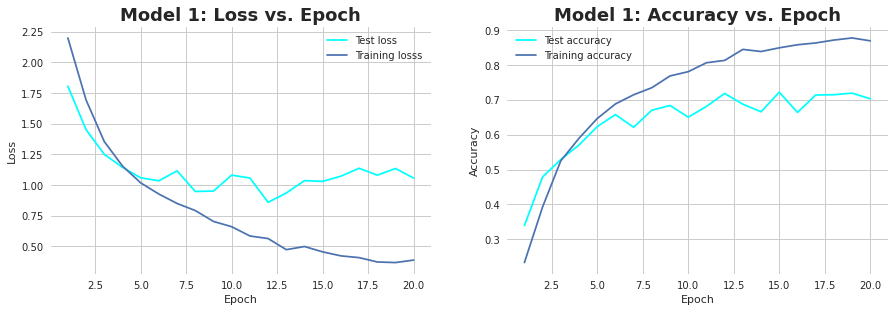

In [45]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,10))
#First Model
ax1 = plt.subplot2grid((2,2),(0,0))
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'cyan', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training losss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.title('Model 1: Loss vs. Epoch',weight='bold', fontsize=18)
ax1 = plt.subplot2grid((2,2),(0,1))
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'cyan', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1: Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()